# Graph Types and Structures Lab --> Project 3 Workspace

In [2]:
import neo4j
import pandas as pd
from IPython.display import display

## Remember the Basics

- Calmly, Orderly, Systematically, Logically... reduce the Search Space
- Expect and make peace with frustration and confusion. Both demonstrate stretching ourselves out of our comfort zone, learning at our maximum potential, not limiting ourselves to what is easy to learn. 

#### Nodes (vertices) can have: labels for classification and properties (attributes as key / value pairs)

#### Relationships (edges) can have: type, direction, and properties (attributes as key / value pairs); 

Additional Reading: 
- https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.bipartite_layout.html
- https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

#### Jupyter Hotkeys for VSC

Creating Cells

1. Create a Code Cell After the Current Position:
• Mac: Option + Enter
	This hotkey will create a new code cell directly below the currently selected cell and move the cursor to the new cell.

2. Create a Markdown Cell After the Current Position:
• Mac: Cmd + Shift + Option + M
	Alternatively, you can convert an existing code cell to a markdown cell using:
	•Mac: M (when the cell is in command mode)

Running Cells

1. Run All Cells Above a Certain Point:
	There isn’t a direct hotkey to run all cells above the current point. However, you can accomplish this by:
	• Command Palette: Cmd + Shift + P (Mac) to open the Command Palette, then type “Run Above” and select “Run Above”.

#### Web server interface at https://xxxx:7473

**Username: neo4j**

**Password: ucb_mids_w205**

The above web server allows and interactive GUI which can output graphs visually in addition to table like output.  The nodes in the graphs can be moved around with the mouse to make the graphs more readable.


#### Basics:

```:server connect``` - connect to the server, username is "neo4j", password is "ucb_mids_w205"

```:server status``` - shows that username and server you are logged into

```:clear``` - clears off old cells

```show databases``` - note that community edition only has 1 application database that we can use neo4j, we cannot create now use other databases, we have to wipe out neo4j database for each new graph

#### Cypher as the query language: 
- analogous to SQL for a relational database; Cypher is open source and like SQL is used for multiple database, Cypher can be used for other graph databases


```()``` node


```[]``` relationships


```-> <-``` directions, every relationship must have 1 and only 1 direction


```(p:Person)``` p is a variable, Person is a node label


```(:Person)``` no variable, Person is a node label


```(p:Person {name: 'John', birth_year: 1970})``` name is a property of the node with value 'John', and birth_year is a property with value 1970


```(p1:Person {name: 'John'})-[r:IS_FRIEND_OF]->(p2:Person {name: 'Mary'})``` r is a variable, IS_FRIEND_OF is a relationship type


```(p1:Person {name: 'John'})-[:IS_FRIEND_OF {since: 1983}]->(p2:Person {name: 'Mary'})``` since is a property of the relationship

```match``` matches a pattern of nodes and/or relationships

```return``` which properties of nodes and/or relationships to return

```order by``` sorting just like SQL

```limit```  limiting the rows returned just like SQL

```collect``` a form of a pivot to turn rows into a list

```unwind``` a form of an unpivot to turn a list into rows

```create``` creates nodes and/or relationships

```delete``` deletes nodes and/or relationships

### Connect, login, create driver, create session; with community edition, we can only use 1 database, the "neo4j" database

In [3]:
# driver = neo4j.GraphDatabase.driver(uri="neo4j://<EXTERNAL_IP>:7687", auth=("neo4j", "ucb_mids_w205"))


In [4]:
# driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

Local -> Cloud access, comment out prior to submitting

In [5]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))

In [6]:
session = driver.session(database="neo4j")

## Function Definitions

### Visualize Graph

In [7]:
# !pip install py2neo
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt


# Function to visualize the graph using networkx
def visualize_graph():
    # Connect to the Neo4j database
    graph = Graph("bolt://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))

    # Define a query to get nodes and relationships
    query = """
    MATCH (n)-[r]->(m)
    RETURN n.name AS from, type(r) AS type, m.name AS to
    """

    # Run the query
    results = graph.run(query)

    # Create a NetworkX graph
    G = nx.DiGraph()

    # Add nodes and edges to the NetworkX graph
    for record in results:
        G.add_edge(record["from"], record["to"], label=record["type"])

    # Choose a layout algorithm
    pos = nx.spring_layout(G, k=0.5)  # k controls the distance between nodes

    # Draw the nodes and edges
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    # Draw the edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Display the graph
    plt.title("Neo4j Graph Visualization")
    plt.show()


### my_neo4j_wipe_out_database() 
- since community edition can only have 1 database "neo4j", this function will wipe out all the nodes and relationships

In [8]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

### my_neo4j_run_query_pandas() 
will run a Cypher query and put the results in a Pandas dataframe; easy to see how you can use Python to manipulate the returned data

In [9]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

### my_neo4j_nodes_relationships() 
- will print the nodes (assumes a name property) and relationships

In [10]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

## Testing Workspace

### Simple graph of several people and who is a friend of whom

In [11]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (john:Person {name: 'John', born: 1970}),
  (mary:Person {name: 'Mary', born: 1972}),
  (mark:Person {name: 'Mark', born: 1968}),
  (linda:Person {name: 'Linda', born: 1967}),
  (larry:Person {name: 'Larry', born: 1965}),
  (john)-[:IS_FRIEND_OF {since: 1983}]->(mary),
  (john)-[:IS_FRIEND_OF {since: 1984}]->(mark),
  (john)-[:IS_FRIEND_OF {since: 1982}]->(linda),
  (mary)-[:IS_FRIEND_OF {since: 1981}]->(larry),
  (mark)-[:IS_FRIEND_OF {since: 1983}]->(larry),
  (linda)-[:IS_FRIEND_OF {since: 1984}]->(larry)

"""

session.run(query)

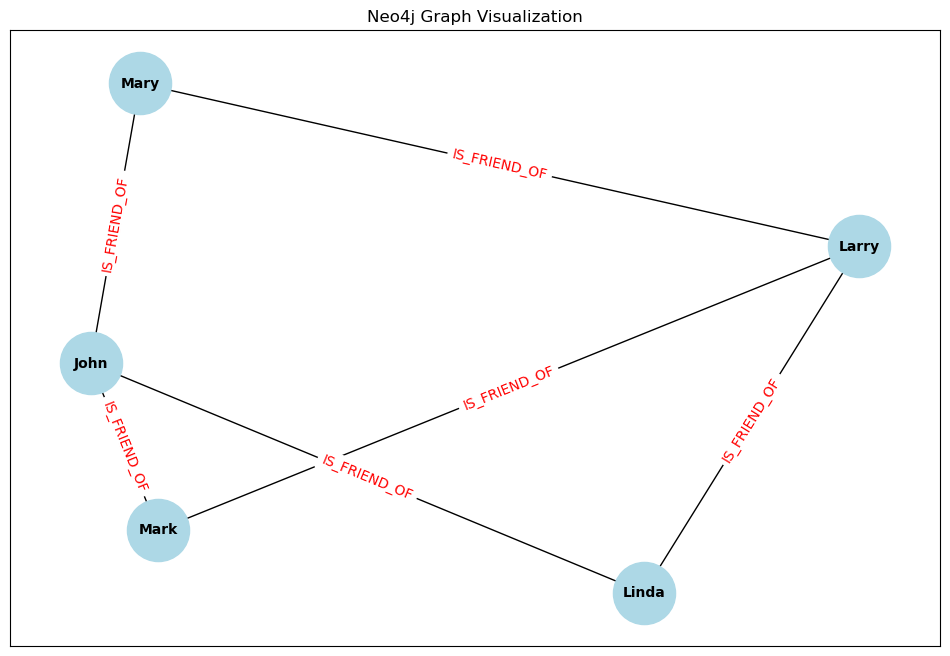

In [12]:
visualize_graph()

In [13]:
print(my_neo4j_nodes_relationships())
my_neo4j_wipe_out_database()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,John,[Person]
1,Larry,[Person]
2,Linda,[Person]
3,Mark,[Person]
4,Mary,[Person]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,John,[Person],IS_FRIEND_OF,Linda,[Person]
1,John,[Person],IS_FRIEND_OF,Mark,[Person]
2,John,[Person],IS_FRIEND_OF,Mary,[Person]
3,Linda,[Person],IS_FRIEND_OF,Larry,[Person]
4,Mark,[Person],IS_FRIEND_OF,Larry,[Person]
5,Mary,[Person],IS_FRIEND_OF,Larry,[Person]


-------------------------
  Density: 0.6
-------------------------
None


## In the Neo4j GUI, run the following query with graph output and rearrange the nodes with your mouse if necessary:

```match (n) return n```

## Random Network - flat, no patterns, all nodes have the same probability of being attached to each other

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (g:Generic {name: 'G'}),
  (h:Generic {name: 'H'}),
  (i:Generic {name: 'I'}),
  (a)-[:IS_CONNECTED_TO]->(e),
  (a)-[:IS_CONNECTED_TO]->(g),
  (b)-[:IS_CONNECTED_TO]->(g),
  (c)-[:IS_CONNECTED_TO]->(f),
  (c)-[:IS_CONNECTED_TO]->(g),
  (d)-[:IS_CONNECTED_TO]->(h),
  (e)-[:IS_CONNECTED_TO]->(h),
  (f)-[:IS_CONNECTED_TO]->(g),
  (f)-[:IS_CONNECTED_TO]->(i)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

## Small-World Network - high degree of local clustering, short average path lengths, hub and spoke, no node more than a few relationships away from any other node

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (g:Generic {name: 'G'}),
  (h:Generic {name: 'H'}),
  (i:Generic {name: 'I'}),
  (j:Generic {name: 'J'}),
  (k:Generic {name: 'K'}),
  (l:Generic {name: 'L'}),
  (m:Generic {name: 'M'}),
  (n:Generic {name: 'N'}),
  (o:Generic {name: 'O'}),
  (p:Generic {name: 'P'}),
  (a)-[:IS_CONNECTED_TO]->(c),
  (a)-[:IS_CONNECTED_TO]->(o),
  (a)-[:IS_CONNECTED_TO]->(i),
  (b)-[:IS_CONNECTED_TO]->(d),
  (b)-[:IS_CONNECTED_TO]->(n),
  (b)-[:IS_CONNECTED_TO]->(o),
  (b)-[:IS_CONNECTED_TO]->(p),
  (c)-[:IS_CONNECTED_TO]->(e),
  (d)-[:IS_CONNECTED_TO]->(i),
  (d)-[:IS_CONNECTED_TO]->(p),
  (e)-[:IS_CONNECTED_TO]->(g),
  (e)-[:IS_CONNECTED_TO]->(h),
  (e)-[:IS_CONNECTED_TO]->(n),
  (f)-[:IS_CONNECTED_TO]->(h),
  (g)-[:IS_CONNECTED_TO]->(i),
  (g)-[:IS_CONNECTED_TO]->(n),
  (h)-[:IS_CONNECTED_TO]->(j),
  (i)-[:IS_CONNECTED_TO]->(k),
  (j)-[:IS_CONNECTED_TO]->(o),
  (k)-[:IS_CONNECTED_TO]->(m),
  (l)-[:IS_CONNECTED_TO]->(n),
  (m)-[:IS_CONNECTED_TO]->(o)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

## Scale-Free Network - hub and spoke in multiple scales, power-law distribution (change in one quantity results in relatively proportional change in another quantity

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (g:Generic {name: 'G'}),
  (h:Generic {name: 'H'}),
  (i:Generic {name: 'I'}),
  (j:Generic {name: 'J'}),
  (k:Generic {name: 'K'}),
  (l:Generic {name: 'L'}),
  (m:Generic {name: 'M'}),
  (n:Generic {name: 'N'}),
  (o:Generic {name: 'O'}),
  (p:Generic {name: 'P'}),
  (q:Generic {name: 'Q'}),
  (a)-[:IS_CONNECTED_TO]->(b),
  (a)-[:IS_CONNECTED_TO]->(c),
  (a)-[:IS_CONNECTED_TO]->(d),
  (b)-[:IS_CONNECTED_TO]->(n),
  (b)-[:IS_CONNECTED_TO]->(o),
  (b)-[:IS_CONNECTED_TO]->(p),
  (b)-[:IS_CONNECTED_TO]->(q),
  (c)-[:IS_CONNECTED_TO]->(j),
  (c)-[:IS_CONNECTED_TO]->(k),
  (c)-[:IS_CONNECTED_TO]->(l),
  (c)-[:IS_CONNECTED_TO]->(m),
  (d)-[:IS_CONNECTED_TO]->(e),
  (d)-[:IS_CONNECTED_TO]->(f),
  (d)-[:IS_CONNECTED_TO]->(g),
  (d)-[:IS_CONNECTED_TO]->(h),
  (d)-[:IS_CONNECTED_TO]->(i)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

# Lab: Neo4j - Connected, Disconnected, Weighted, Unweighted

## Connected - path between any 2 nodes (regardless of the distance), all graphs we have seen up until now have been connected

## Disconnected - some nodes may not be connected to other nodes, "islands" - group of connected nodes disconnected from the main graph

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (g:Generic {name: 'G'}),
  (h:Generic {name: 'H'}),
  (i:Generic {name: 'I'}),
  (a)-[:IS_CONNECTED_TO]->(b),
  (a)-[:IS_CONNECTED_TO]->(c),
  (d)-[:IS_CONNECTED_TO]->(e),
  (f)-[:IS_CONNECTED_TO]->(g),
  (f)-[:IS_CONNECTED_TO]->(h),
  (f)-[:IS_CONNECTED_TO]->(i),
  (g)-[:IS_CONNECTED_TO]->(h),
  (h)-[:IS_CONNECTED_TO]->(i)

"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

## Unweighted - no numeric value placed on the relationships, all the graphs we have seen up until now have been unweighted, some algorithms require weights, some algorithms do not consider weights, some algoritms default unweighted to a weight of 1 

## Weighted - numeric values placed on a relationship

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A', weight: 5}),
  (b:Generic {name: 'B', weight: 7}),
  (c:Generic {name: 'C', weight: 8}),
  (d:Generic {name: 'D', weight: 3}),
  (e:Generic {name: 'E', weight: 4}),
  (a)-[:IS_CONNECTED_TO {weight: 110}]->(b),
  (a)-[:IS_CONNECTED_TO {weight: 120}]->(c),
  (b)-[:IS_CONNECTED_TO {weight: 123}]->(c),
  (c)-[:IS_CONNECTED_TO {weight: 127}]->(d),
  (d)-[:IS_CONNECTED_TO {weight: 117}]->(e)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

# Lab: Neo4j - Cyclic, Acyclic, Trees

## Cyclic  - has cycles, path from a node back to itself, some algorithms can get stuck in cycles

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (a)-[:IS_CONNECTED_TO]->(c),
  (c)-[:IS_CONNECTED_TO]->(d),
  (d)-[:IS_CONNECTED_TO]->(a),
  (d)-[:IS_CONNECTED_TO]->(e),
  (c)-[:IS_CONNECTED_TO]->(b),
  (b)-[:IS_CONNECTED_TO]->(f),
  (f)-[:IS_CONNECTED_TO]->(c)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

## Acyclic - no cycles, no node has a path back to itself, a lot of algorithms require acyclic

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (g:Generic {name: 'G'}),
  (a)-[:IS_CONNECTED_TO]->(c),
  (a)-[:IS_CONNECTED_TO]->(d),
  (a)-[:IS_CONNECTED_TO]->(f),
  (c)-[:IS_CONNECTED_TO]->(b),
  (c)-[:IS_CONNECTED_TO]->(g),
  (d)-[:IS_CONNECTED_TO]->(e)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

## Trees - acyclic graphs, spanning tree - all nodes in a graph with relationships removed to remove cycles; we will take our cyclic graph example and remove relationships until we have a spanning tree

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a1:Generic {name: 'A1'}),
  (b1:Generic {name: 'B1'}),
  (c1:Generic {name: 'C1'}),
  (d1:Generic {name: 'D1'}),
  (e1:Generic {name: 'E1'}),
  (f1:Generic {name: 'F1'}),
  (a1)-[:IS_CONNECTED_TO]->(c1),
  (c1)-[:IS_CONNECTED_TO]->(d1),
  (d1)-[:IS_CONNECTED_TO]->(a1),
  (d1)-[:IS_CONNECTED_TO]->(e1),
  (c1)-[:IS_CONNECTED_TO]->(b1),
  (b1)-[:IS_CONNECTED_TO]->(f1),
  (f1)-[:IS_CONNECTED_TO]->(c1),
  (a2:Generic {name: 'A2'}),
  (b2:Generic {name: 'B2'}),
  (c2:Generic {name: 'C2'}),
  (d2:Generic {name: 'D2'}),
  (e2:Generic {name: 'E2'}),
  (f2:Generic {name: 'F2'}),
  (a2)-[:IS_CONNECTED_TO]->(c2),
  (c2)-[:IS_CONNECTED_TO]->(b2),
  (b2)-[:IS_CONNECTED_TO]->(f2),
  (c2)-[:IS_CONNECTED_TO]->(d2),
  (d2)-[:IS_CONNECTED_TO]->(e2)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

# Lab: Neo4j - Density Calculations, Sparse Graphs, Dense Graphs

## Density Calculations:

* Maximum Density = (nodes (nodes - 1) ) / 2


* Actual Density = (2 * relationships) / (nodes * (nodes - 1) )

## Sparce Graph - low density 

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (a)-[:IS_CONNECTED_TO]->(b),
  (b)-[:IS_CONNECTED_TO]->(c),
  (c)-[:IS_CONNECTED_TO]->(d),
  (d)-[:IS_CONNECTED_TO]->(e),
  (e)-[:IS_CONNECTED_TO]->(f)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

## Dense Graph - high density

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (a)-[:IS_CONNECTED_TO]->(b),
  (a)-[:IS_CONNECTED_TO]->(c),
  (a)-[:IS_CONNECTED_TO]->(d),
  (a)-[:IS_CONNECTED_TO]->(f),
  (b)-[:IS_CONNECTED_TO]->(c),
  (b)-[:IS_CONNECTED_TO]->(d),
  (b)-[:IS_CONNECTED_TO]->(e),
  (b)-[:IS_CONNECTED_TO]->(f),
  (c)-[:IS_CONNECTED_TO]->(d),
  (c)-[:IS_CONNECTED_TO]->(e),
  (c)-[:IS_CONNECTED_TO]->(f),
  (d)-[:IS_CONNECTED_TO]->(e),
  (d)-[:IS_CONNECTED_TO]->(f),
  (e)-[:IS_CONNECTED_TO]->(f)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

# Lab: Neo4j - Monopartite, Bipartite, k-Partite Graphs

## Monopartitie - 1 node label, 1 relationship type, all graphs we have seen so far are monopartitie

## Bipartite - two sets, nodes from one set only connect to nodes in the other set

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (john:Person {name: 'John'}),
  (mary:Person {name: 'Mary'}),
  (linda:Person {name: 'Linda'}),
  (a:Club {name: 'Club A'}),
  (b:Club {name: 'Club B'}),
  (c:Club {name: 'Club C'}),
  (mary)-[:IS_MEMBER_OF]->(a),
  (mary)-[:IS_MEMBER_OF]->(b),
  (mary)-[:IS_MEMBER_OF]->(c),
  (linda)-[:IS_MEMBER_OF]->(a),
  (john)-[:IS_MEMBER_OF]->(b),
  (john)-[:IS_MEMBER_OF]->(c)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()

## k-Partite - k sets, nodes from one set only connect to nodes in another set, most real world graphs have a high k value; in this example k=4: Person, Club, Course, Day

In [ ]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (john:Person {name: 'John'}),
  (mary:Person {name: 'Mary'}),
  (linda:Person {name: 'Linda'}),
  (a:Club {name: 'Club A'}),
  (b:Club {name: 'Club B'}),
  (c:Club {name: 'Club C'}),
  (ds:Course {name: 'Data Structures'}),
  (as:Course {name: 'Assembler'}),
  (st:Course {name: 'Statictics'}),
  (lt:Course {name: 'Laplace Transform'}),
  (tu:Day {name: 'Tuesday'}),
  (th:Day {name: 'Thursday'}),
  (mary)-[:IS_MEMBER_OF]->(a),
  (mary)-[:IS_MEMBER_OF]->(b),
  (mary)-[:IS_MEMBER_OF]->(c),
  (linda)-[:IS_MEMBER_OF]->(a),
  (john)-[:IS_MEMBER_OF]->(b),
  (john)-[:IS_MEMBER_OF]->(c),
  (mary)-[:IS_TAKING]->(st),
  (mary)-[:IS_TAKING]->(lt),
  (linda)-[:IS_TAKING]->(ds),
  (linda)-[:IS_TAKING]->(st),
  (linda)-[:IS_TAKING]->(lt),
  (john)-[:IS_TAKING]->(as),
  (ds)-[:TAUGHT_ON]->(tu),
  (st)-[:TAUGHT_ON]->(tu),
  (as)-[:TAUGHT_ON]->(th),
  (lt)-[:TAUGHT_ON]->(th)
  
"""

session.run(query)

In [ ]:
my_neo4j_nodes_relationships()

In [ ]:
# Visualize the Random Network
visualize_graph()